# Описание гипотезы
### Проверим предположения
1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Проверить, насколько прозрачен процесс взаимодействия с игрой.
#### Проверять будем на данных пользователей, зарегистрированных в 2018 году (1 января 2018 - 31 декабря 2018)

Импротируем нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Загружаем данные

In [2]:
events_df = pd.read_csv('data/7_4_Events.csv', sep=',')
purchase_df = pd.read_csv('data/purchase.csv', sep=',')

## Производим предобработку данных

Выделяем пользователей зарегистрирванных в 2018 году и загружаем данные по ним в отдельные датафреймы

In [3]:
# Создаем фильтр по пользователям, зарегистрировавшихся в 2018 году
mask = (events_df['start_time'] >= '2018-01-01') & (events_df['start_time'] < '2019-01-01') & (events_df['event_type'] == 'registration')

regist_2018 = events_df[mask]['user_id'].to_list() # список пользователей зарегистрировавшихся в 2018 году 

events_2018 = events_df[events_df['user_id'].isin(regist_2018)].copy() # отбираем все записи с этими пользователями в таблице events
purchase_2018 = purchase_df[purchase_df['user_id'].isin(regist_2018)].copy() # отбираем все записи с этими пользователями в таблице purchase


Преобразуем даты в полученых датафреймах

In [4]:
purchase_2018['event_datetime'] = pd.to_datetime(purchase_2018['event_datetime'])
events_2018['start_time'] = pd.to_datetime(events_2018['start_time'])

Перед объединением датафреймов, переименуем колонки идентификаторов

In [5]:
events_2018 = events_2018.rename(columns={'id':'event_id'})
purchase_2018 = purchase_2018.rename(columns={'id':'purchase_id'})
purchase_2018['start_time'] = purchase_2018['event_datetime']
purchase_2018['event_type'] = 'purchase'

Вычисляем время после обучения и до выбора уровня или наоборот, понадобится во 2-й гипотезе

In [6]:
events_2018['time_diff_tutlevel'] = events_2018[(events_2018['event_type']=='tutorial_finish') | (events_2018['event_type']=='level_choice')].groupby(by=['user_id'])['start_time'].diff()

Сделаем объединенный датафрейм из событий и оплат

In [7]:
total_events_df = pd.concat([events_2018,purchase_2018],sort=False)
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')

### Проверим 1-ю гипотезу
* Насколько обучение сокращает время прохождения этапов игры

Сформируем группы пользователей, которые проходили обучение и которые не проходили

In [8]:
mask_tutorial = total_events_df['event_type']=='tutorial_finish'
mask_first_tutorial = (total_events_df['event_type']=='level_choice') & (total_events_df['time_diff_tutlevel'] > '00:00:00')
mask_second_tutorial = (total_events_df['event_type']=='tutorial_finish') & (total_events_df['time_diff_tutlevel'] > '00:00:00')
# Пользователи которые прошли обучение
users_tutorial_finish = total_events_df[mask_tutorial]['user_id'].unique()
print('Количество пользователей завершивших обучение: {}'.format(len(users_tutorial_finish)))
# Пользователи которые проходили обучение до прохождения всех этапов
users_tutorial_finish_before = total_events_df[(total_events_df['user_id'].isin(users_tutorial_finish)) & (mask_first_tutorial)]['user_id'].unique()
users_tutorial_finish_after = total_events_df[(total_events_df['user_id'].isin(users_tutorial_finish)) & (mask_second_tutorial)]['user_id'].unique()
# Пользователи которые не проходили обучение
users_not_tutorial = total_events_df[~(total_events_df['user_id'].isin(users_tutorial_finish))]['user_id'].unique()
print('Количество пользователей не проходивших обучение: {}'.format(len(users_not_tutorial)))

Количество пользователей завершивших обучение: 10250
Количество пользователей не проходивших обучение: 9676


In [9]:
print('Из пользователей которые прошли обучение:')
print('Прошли обучение, затем остальные этапы игры: {}'.format(len(users_tutorial_finish_before)))
print('Прошли обучение после выбора уровня: {}'.format(len(users_tutorial_finish_after)))
print('Всего: {}'.format(len(users_tutorial_finish_before)+len(users_tutorial_finish_after)))

Из пользователей которые прошли обучение:
Прошли обучение, затем остальные этапы игры: 7501
Прошли обучение после выбора уровня: 2235
Всего: 9736


Как видим, пользователей которые выбирали этапы игры после или до обучения меньше, чем всего пользователей прошедших обучение, значит не все пользователи которые проходили обучение продолжали игру дальше.

Разобьем пользователей на группы

In [10]:
total_events_df['groups'] = total_events_df.apply(lambda x: 1 if x['user_id'] in users_tutorial_finish else 0, axis=1)

Сформируем сводную таблицу прохождения этапов игры

In [11]:
users_etap = total_events_df.pivot_table(
    values='start_time',
    index=['user_id','groups'],
    columns='event_type',
    aggfunc='min'
)

Вычислим разницу во времени прохождения этапов игры

In [12]:
users_etap['level_diff'] = users_etap['level_choice'] - users_etap['registration']
users_etap['pack_diff'] = users_etap['pack_choice'] - users_etap['level_choice']
users_etap['purchase_diff'] = users_etap['purchase'] - users_etap['pack_choice']

Вычислим среднее время прохождения по группам

In [13]:
group_avg = users_etap.groupby(by='groups')[['level_diff','pack_diff','purchase_diff']].mean()
group_avg['time_diff'] = group_avg['level_diff'] + group_avg['pack_diff'] + group_avg['purchase_diff']

Переводим timedelta64 (которая исчесляется в наносекундах) в часы

In [14]:
group_avg['time_diff'] = group_avg['time_diff'] / np.timedelta64(1, 'h')

Строим график

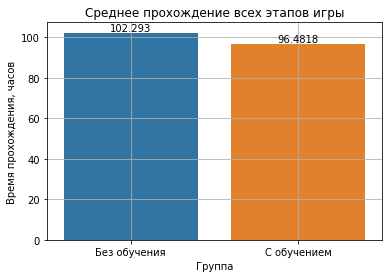

In [15]:
x1 = np.array(['Без обучения','С обучением'])
fig_tg = sns.barplot(
    x=group_avg.index,
    y='time_diff',
    data=group_avg,
    dodge=False,
)
for container in fig_tg.containers:
    fig_tg.bar_label(container)

fig_tg.set_title('Среднее прохождение всех этапов игры');
fig_tg.set_xlabel('Группа');
fig_tg.set_ylabel('Время прохождения, часов');
fig_tg.set_xticklabels(x1)
fig_tg.grid()


### Вывод:
`Прохождение обучения положительно сказывается на времени прохождения этапов игры.`

* `Среднее время прохождения этапов игры у игроков без обучения 102,3 часа.`
* `Среднее время прохождения этапов игры у игроков прошедших обучение 96,5 часов, что почти на 6 часов меньше!`

***

### Проверим 2-ю гипотезу
* Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.

Проверим количество игроков сделавших покупку, которые прошли обучение и которые не проходили обучение

In [16]:
purchase_count_df = total_events_df[total_events_df['event_type']=='purchase'].groupby(by=['groups'])['user_id'].count()
purchase_amount_df = total_events_df[total_events_df['event_type']=='purchase'].groupby(by=['groups'])['amount'].sum()

Выводим график по количеству пользователей сделавших оплату и суммам оплат

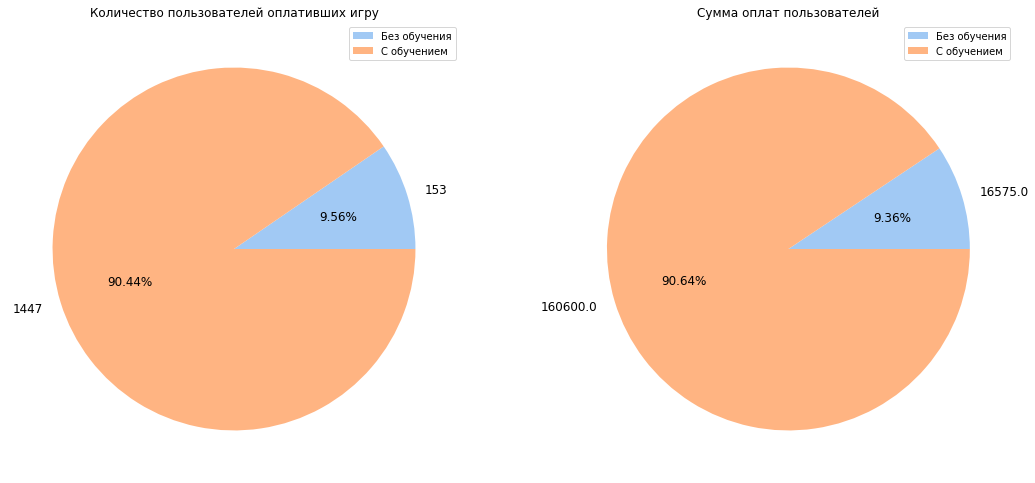

In [17]:
colors = sns.color_palette('pastel')
# Кол-во пользователей
fig = plt.figure(figsize=(14,7), facecolor='white', edgecolor='black')

pie1_axes = fig.add_axes([0,0,0.45,1])
pie1_axes.pie(
    data=purchase_count_df,
    x=purchase_count_df,
    labels=purchase_count_df,
    colors=colors,
    autopct = '%0.2f%%',
    textprops = {'color': 'black','fontsize':12}
    
);
pie1_axes.set_title('Количество пользователей оплативших игру')
pie1_axes.legend(x1);
# Суммы оплат
pie2_axes = fig.add_axes([0.55,0,0.45,1])
pie2_axes.pie(
    data=purchase_amount_df,
    x=purchase_amount_df,
    labels=purchase_amount_df,
    colors=colors,
    autopct = '%0.2f%%',
    textprops = {'color': 'black','fontsize':12}
);
pie2_axes.set_title('Сумма оплат пользователей')
pie2_axes.legend(x1);

### Вывод:
- `Количество пользователей сделавших оплату примерно в 10 раз больше, среди пользователей прошедших обучение. Примерно такое же соотношение в суммах сделаных оплат.
Из этого следует, что само по себе обучение положительно влияет на последующую оплату.`


Проверим, какой процент оплат среди пользователей которые сначала прошли обучение, а затем другие этапы игры и наоборот

* Выделяем пользователей и разбиваем по группам

In [18]:
total_tutorial_users = total_events_df[total_events_df['groups']==1]
total_tutorial_users['tutor_after'] = total_tutorial_users.apply(lambda x: 1 if x['user_id'] in users_tutorial_finish_after else 0, axis=1)

C:\Users\Raptor\AppData\Local\Temp\ipykernel_17616\3765863053.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_tutorial_users['tutor_after'] = total_tutorial_users.apply(lambda x: 1 if x['user_id'] in users_tutorial_finish_after else 0, axis=1)


In [19]:
# Считаем 
tutor_df = total_tutorial_users.groupby('tutor_after')['amount'].sum() / total_tutorial_users.groupby('tutor_after')['amount'].count()

Выводим график

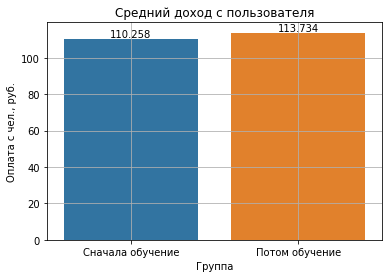

In [20]:
x2 = np.array(['Сначала обучение','Потом обучение'])
fig_tutor = sns.barplot(
    x=tutor_df.index,
    y=tutor_df.values,
    data=tutor_df,
    dodge=False,
)
for container in fig_tutor.containers:
    fig_tutor.bar_label(container)

fig_tutor.set_title('Средний доход с пользователя');
fig_tutor.set_xlabel('Группа');
fig_tutor.set_ylabel('Оплата с чел., руб.');
fig_tutor.set_xticklabels(x2)
fig_tutor.grid()

### Вывод:
- `Как видим, сумма оплат практически не зависит от того, проходил пользователь сначала обучение, потом другие этапы игры или сначала попробовал играть, а затем прошел обучение.`

***
### Проверим 3-ю гипотезу
#### Проверить, насколько прозрачен процесс взаимодействия с игрой.

- Для этого посчитаем процент тех пользователей, которые возвращались в обучение после выбора уровня сложности, от игроков которые не проходили обучение и не возвращались к нему.

In [28]:
p_users_back2tutorial = len(users_tutorial_finish_after) / (len(users_not_tutorial) + len(users_tutorial_finish_after))
print('Процент пользователей, которые возвращались к обучению после выбора уровня: {:.2%}'.format(p_users_back2tutorial))

Процент пользователей, которые возвращались к обучению после выбора уровня: 18.76%


### Вывод:
- `Процент пользователей прошедших обучение после того, как сначала выбрали уроевень равна около 19%, что означает, что процесс взаимодействия с игрой достаточно прозрачен!`

## Подведем итоги
1. Прохождение обучения положительно сказывается на времени прохождения этапов игры.
2. Обучение положительно влияет на последующую оплату и не важно каким этапом проходило обучение.
3. Процесс взаимодействия с игрой достаточно прозрачен.